# HERE WAS A PROBLEM WITH SAMPLE LOADING

**word vectors had words changed to sample quite often by mistake**

# HERE WAS A PROBLEM WITH SAMPLE LOADING, DO NOT USE

# HERE WAS A PROBLEM WITH SAMPLE LOADING, DO NOT USE

In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_1 import *

Pytorch utils oh: pytorch_utils_oh_1.py
Pytorch: 0.2.0_4


In [2]:
MODEL_SAVE_PATH = 'category_2_mod_data_word_vecs'

In [38]:
import pytorch_utils_oh_1; importlib.reload(pytorch_utils_oh_1); from pytorch_utils_oh_1 import *;

Pytorch utils oh: pytorch_utils_oh_1.py
Pytorch: 0.2.0_4


# Data loading

In [4]:
all_data = pickle.load(open("data/en_train_not_changed_1.pkl", "rb" ))
all_data_sentence_index = all_data.set_index('sentence_id')

In [5]:
all_data.sample(5)

,sentence_id,token_id,class,before,after
4832931,369780,13,NOT_CHANGED,on,on
6057854,461517,3,NOT_CHANGED,was,was
3008411,232431,2,NOT_CHANGED,Olga,Olga
1189637,93851,9,NOT_CHANGED,in,in
1659951,129912,7,ELECTRONIC,whitney.orgGeorgina,w h i t n e y dot o r g g e o r g i n a


In [6]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NOT_CHANGED' 'NUMBERS' 'LETTERS' 'PLAIN' 'VERBATIM' 'ELECTRONIC']
6


### More balanced sample

In [7]:
all_data.groupby("class")["class"].count()

class
ELECTRONIC        4964
LETTERS         144364
NOT_CHANGED    9218584
NUMBERS         448151
PLAIN            36472
VERBATIM         65855
Name: class, dtype: int64

In [8]:
balanced_data_classes_select = list(all_data.groupby('class'))
def balanced_data_randomize(max_len=20000):
    global balanced_data
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
balanced_data_randomize()

In [9]:
balanced_data.groupby("class")["class"].count()

class
ELECTRONIC      4964
LETTERS        20000
NOT_CHANGED    20000
NUMBERS        20000
PLAIN          20000
VERBATIM       20000
Name: class, dtype: int64

### Letters all

In [10]:
tmp = sorted(list(set(''.join(all_data['before']))))
characters_all = ['<EOS>', '<SOS>'] + sorted(list(set(tmp)))
characters_all_index = dict((c, i) for i, c in enumerate(characters_all))
print(''.join(characters_all))
print(len(characters_all))

<EOS><SOS> !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞☒
115


### Word vectors

In [11]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

# Samples

In [12]:
def get_random_sample():
    sample_row = balanced_data.iloc[random.randint(1, len(balanced_data)-1)]
    sentence_id = sample_row['class']

    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = SAMPLE_WORD_TOKEN

    return sample_row['before'], sample_row['after'], sample_row['class'], befores
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(' '.join(s_sentence))
    print(s_sentence)
    print(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx).shape)
    print(string_to_tensor(s_bef, characters_all_index).shape)
tmp()

NOT_CHANGED : Michael -> Michael
He grew up in a terraced house along with his brother , <SAMPLE> .
['He' 'grew' 'up' 'in' 'a' 'terraced' 'house' 'along' 'with' 'his'
 'brother' ',' '<SAMPLE>' '.']
torch.Size([1, 14, 50])
torch.Size([1, 8, 115])


# Model

In [13]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(words_hidden_size+chars_hidden_size, output_size)
        
    def forward(self, words_tensor, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(words_tensor, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [14]:
model = CategorizeRNN(len(categories_all), 
                      words_input_size=wv_vecs.shape[-1], chars_input_size=len(characters_all),
                      words_hidden_size=128, chars_hidden_size=128,
                      words_layers=1, chars_layers=1)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_2_mod_data_word_vecs


CategorizeRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(115, 64, batch_first=True, bidirectional=True)
  (lin_output): Linear (256 -> 6)
)

In [15]:
models_save_path = 'category_2_word_vecs'

In [16]:
model_training = ModelTraining(models_save_path, [model])

Save path: data/models/category_2_word_vecs


### Accuracy

In [22]:
def test_model_single_sample(model):
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    words_t = words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)
    string_t = string_to_tensor(s_bef, characters_all_index)
    
    words_t = Variable(words_t).cuda()
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    guess = category_from_output(output, categories_all)
    return output, guess, (s_class, categories_index[s_class])
    
tmp = test_model_single_sample(model)
tmp

(Variable containing:
 -1.7417 -1.8090 -1.8414 -1.7969 -1.7989 -1.7658
 [torch.cuda.FloatTensor of size 1x6 (GPU 0)],
 ('NOT_CHANGED', 0),
 ('VERBATIM', 4))

In [23]:
%%time
test_model_accuracy(model, test_model_single_sample)

Accuracy: 17.28% (    1728/   10000)
CPU times: user 28 s, sys: 960 ms, total: 29 s
Wall time: 27.8 s


0.1728

### Training

In [24]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()
    
    words_t = words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)
    string_t = string_to_tensor(s_bef, characters_all_index)

    words_t = Variable(words_t).cuda()
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [25]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result, categories_all)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 10000 == 0 or model_training.iterations == 10:
            balanced_data_randomize()
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model, test_model_single_sample)
            model.train()
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [26]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

    19  18% (   0m 0s)   1.816   |   1.84: DJs -> NOT_CHANGED (✗ LETTERS)
    28  36% (   0m 0s)   1.798   |   1.84: CVS -> NOT_CHANGED (✗ LETTERS)
    37  54% (   0m 0s)   1.797   |   1.80: 3.86 -> NOT_CHANGED (✗ NUMBERS)
    46  72% (   0m 0s)   1.802   |   1.83: enfranchised -> NOT_CHANGED (✗ PLAIN)
    55  90% (   0m 0s)   1.802   |   1.83: - -> NOT_CHANGED (✗ PLAIN)


In [27]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   560  53% (   0m 3s)   1.744   |   1.83: CDL -> NOT_CHANGED (✗ LETTERS)


In [28]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (   0m 7s)   1.516   |   2.89: CpGs -> NOT_CHANGED (✗ VERBATIM)
  3000  20% (  0m 13s)   1.247   |   0.50: 1950 -> NUMBERS (✓)
  4000  30% (  0m 20s)   1.048   |   0.26: 1857 -> NUMBERS (✓)
  5000  40% (  0m 27s)   0.914   |   0.65: single -> NOT_CHANGED (✓)
  6000  50% (  0m 33s)   0.827   |   0.81: Laughing -> NOT_CHANGED (✓)
  7000  60% (  0m 40s)   0.809   |   1.86: Capturing -> PLAIN (✗ NOT_CHANGED)
  8000  70% (  0m 46s)   0.764   |   1.64: cand.theol -> PLAIN (✗ ELECTRONIC)
  9000  80% (  0m 53s)   0.668   |   0.03: ☒ -> VERBATIM (✓)
 10000  90% (   1m 0s)   0.664   |   1.42: of -> PLAIN (✗ NOT_CHANGED)
 11000 100% (   1m 7s)   0.606   |   1.22: es -> PLAIN (✗ LETTERS)


In [29]:
train_iterations(n_iters=100000, print_every=10000)

 21000  10% (   1m 6s)   0.270   |   1.15: etc -> NOT_CHANGED (✗ PLAIN)
 31000  20% (  2m 13s)   0.156   |   0.00: ☒ -> VERBATIM (✓)
 41000  30% (  3m 20s)   0.153   |   0.03: writing -> NOT_CHANGED (✓)
Saved model to data/models/category_2_word_vecs/50000_(CategorizeRNN)
Accuracy: 96.09% (    9609/   10000)
 51000  40% (  4m 52s)   0.135   |   0.03: against -> NOT_CHANGED (✓)
 61000  50% (  5m 59s)   0.121   |   0.00: , -> NOT_CHANGED (✓)
 71000  60% (   7m 5s)   0.093   |   0.02: Organisation -> PLAIN (✓)
 81000  70% (  8m 11s)   0.110   |   0.00: dialogue -> PLAIN (✓)
 91000  80% (  9m 17s)   0.097   |   0.00: ☒ -> VERBATIM (✓)
Saved model to data/models/category_2_word_vecs/100000_(CategorizeRNN)
Accuracy: 97.77% (    9777/   10000)
101000  90% ( 10m 52s)   0.076   |   0.00: 1973 -> NUMBERS (✓)
111000 100% ( 11m 56s)   0.057   |   0.02: : -> PLAIN (✓)


In [30]:
train_iterations(n_iters=100000, print_every=10000)

121000  10% (   1m 8s)   0.047   |   0.00: ☒ -> VERBATIM (✓)
131000  20% (  2m 17s)   0.093   |   0.00: ☒ -> VERBATIM (✓)
141000  30% (  3m 23s)   0.054   |   0.02: rd -> PLAIN (✓)
Saved model to data/models/category_2_word_vecs/150000_(CategorizeRNN)
Accuracy: 98.23% (    9823/   10000)
151000  40% (  4m 56s)   0.057   |   0.00: PM -> LETTERS (✓)
161000  50% (   6m 1s)   0.066   |   0.00: ☒ -> VERBATIM (✓)
171000  60% (   7m 6s)   0.050   |   0.00: & -> VERBATIM (✓)
181000  70% (  8m 10s)   0.069   |   0.01: SC -> LETTERS (✓)
191000  80% (  9m 12s)   0.060   |   0.00: IOC -> LETTERS (✓)
Saved model to data/models/category_2_word_vecs/200000_(CategorizeRNN)
Accuracy: 98.41% (    9841/   10000)
201000  90% ( 10m 38s)   0.064   |   0.00: pp -> VERBATIM (✓)
211000 100% ( 11m 39s)   0.048   |   0.00: Gay.com -> ELECTRONIC (✓)


In [37]:
train_iterations(n_iters=300000, lr=0.0001, print_every=25000)

236000   8% (  3m 30s)   0.051   |   0.00: ☒ -> VERBATIM (✓)
Saved model to data/models/category_2_word_vecs/250000_(CategorizeRNN)
Accuracy: 98.85% (    9885/   10000)
261000  17% (  7m 35s)   0.044   |   0.00: D. -> LETTERS (✓)
286000  25% (  11m 9s)   0.026   |   0.00: 2009 -> NUMBERS (✓)
Saved model to data/models/category_2_word_vecs/300000_(CategorizeRNN)
Accuracy: 98.86% (    9886/   10000)
311000  33% ( 14m 50s)   0.032   |   0.00: # -> VERBATIM (✓)
336000  42% ( 17m 50s)   0.029   |   0.00: jr -> PLAIN (✓)
Saved model to data/models/category_2_word_vecs/350000_(CategorizeRNN)
Accuracy: 98.95% (    9895/   10000)
361000  50% ( 21m 17s)   0.034   |   0.00: dr -> PLAIN (✓)
386000  58% ( 24m 17s)   0.038   |   0.00: be -> NOT_CHANGED (✓)
Saved model to data/models/category_2_word_vecs/400000_(CategorizeRNN)
Accuracy: 98.98% (    9898/   10000)
411000  67% ( 27m 51s)   0.029   |   0.00: metres -> PLAIN (✓)
436000  75% ( 30m 49s)   0.019   |   0.00: Edge.org -> ELECTRONIC (✓)
Saved 

# Results

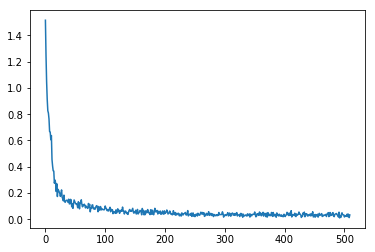

In [39]:
plt.figure()
plt.plot(model_training.losses)

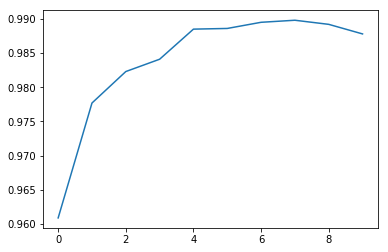

In [40]:
plt.figure()
plt.plot(model_training.accuracy)

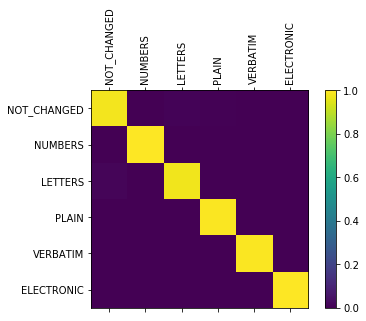

Accuracy: 99.03% (   49513/   50000)
CPU times: user 2min 12s, sys: 2.63 s, total: 2min 14s
Wall time: 2min 15s


In [41]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample, n_confusion=50000)

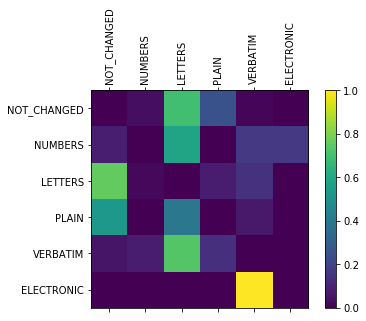

Accuracy: 99.08% (   49539/   50000)
CPU times: user 2min 4s, sys: 2.38 s, total: 2min 7s
Wall time: 2min 6s


In [42]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)